# Recommending Web Articles (Feature Extraction & Clustering) 
By: MAHMOUD NAGY | MAY 2022

> **NOTE:**
> - We are going to use only **body** in this notebook,
> - and will use **TF-IDF** to extract features from text 

> - Using the article body requires high computational power, 
> - as we get way more dimentions.
> - We will use random projection instead of PCA, 
> - as it will be computationally more efficient

## Table of Contents
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

https://stats.stackexchange.com/questions/350339/how-to-split-data-into-training-and-testing-for-clustering <br>
https://scikit-learn.org/stable/modules/clustering.html

**Your team leader requests from you**
- build a classifier for the articles that can use in the recommendation. <br>
- In addition to, grouping the articles under each category into multiple groups, for example: <br>
Articles with the **Engineering** category will be grouped into **4 groups** each group with a dummy name e.g. group1, group2, ... etc. 
    - group1 will be mapped into software design 
    - group2 will be mapped into mobile development 

**you are responsible only for the grouping, they need only:** <br>
<font color='blue'> Engineering </font>
- group1 = [Article#1, Article#5, Article#9, ... etc.]
- group2 = [Article#2, Article#15, Article#91, ... etc.]
- group3 = [Article#10, Article#25, Article#90, ... etc.]
- group4 = [Article#11, Article#4, Article#6, ... etc.] 

<font color='blue'> and other categories. <br>
.<br>
.<br>
.</font>


**Feel free to choose your classification algorithm and all the pre-processing needed on the data.**

The team shares with you a JSON file for a group of categorized articles as you will divide those articles into 3 groups: training data, validating data, and testing data. 
To measure the accuracy of each algorithm, at this level you will measure the accuracy by the percent of matching only.

**What we expected:**
A GitHub repository includes:
- Your **Notebook** with the code you used in cleaning and analyzing the data + your model + evaluation.
- **JSON file** for the clusters output (to each category).
- **PDF file** for the evaluation report that will be delivered to the leader (Make sure to mention all your steps in visualizing your results).

<a id='load'></a>
## Step 0: Load the Data
<ul>
    <li><a href="#load"><b>Step 0: Load the Data</b></a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [1]:
from time import time
import pandas as pd
import numpy as np 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import re
import regex

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Fix random seed
np.random.seed(42)

import importlib
importlib.reload(helper)

<module 'helper' from '/Users/mnagy99/jupyter/Knowledge Officer Assignment/Recommending Web Articles/helper.py'>

In [2]:
df = pd.read_csv('clean_data.csv')
print(df.shape)
df.head()

(2454, 5)


,body,title,category,title_clean,body_clean
0,The Founder Institute’s “Startup Tips and Tric...,Make Your Entrepreneurial Journey Sufficientl...,Startups & Business,make entrepreneurial journey sufficiently epic...,founder institute startup tips tricks series g...
1,JAXenter: Have microservices helped you achiev...,"""The size of a microservice is the size of the...",Engineering,size microservice size team building,jaxenter microservices helped achieve goals av...
2,Interview with Fabian Reinartz and Björn Raben...,"""Transition to microservices while running und...",Engineering,transition microservices running full steam easy,interview fabian reinartz bjrn rabenstein soun...
3,Why do many companies sprint from initial conc...,01 MarGo to Market Fit: Achieving Sustainable ...,Startups & Business,margo market achieving sustainable growth,many companies sprint initial concept product ...
4,1. Advisors\n\nChoose experienced advisors ear...,1. Advisors,Startups & Business,advisors,advisors choose experienced advisors early inc...


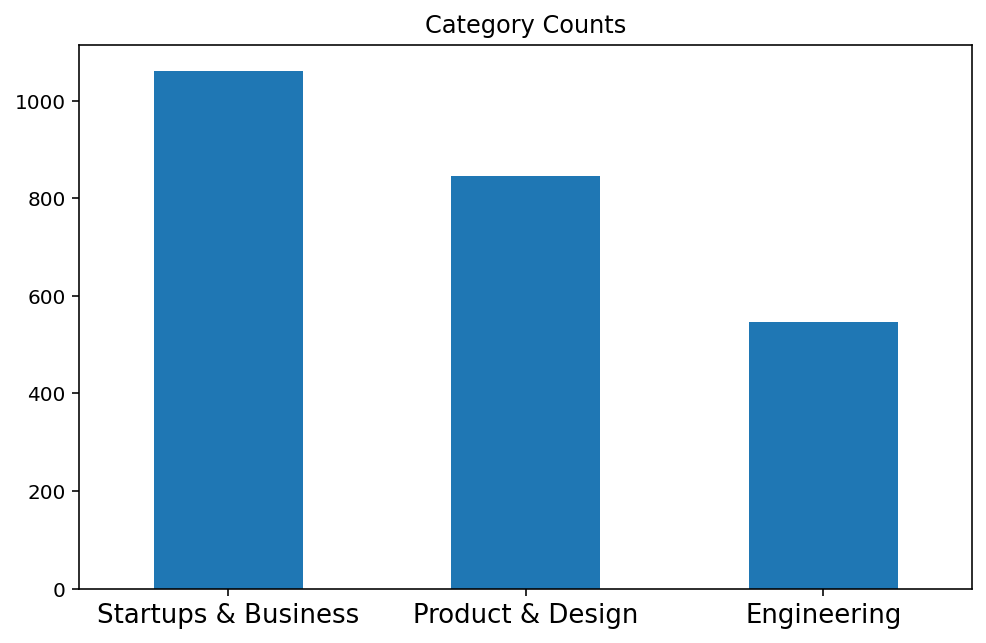

In [3]:
df.category.value_counts().plot(kind = 'bar', figsize = (8,5)  );
plt.title('Category Counts');
plt.xticks(rotation=0, size=13);

In [4]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

<br>

**Add a Word Count Column**

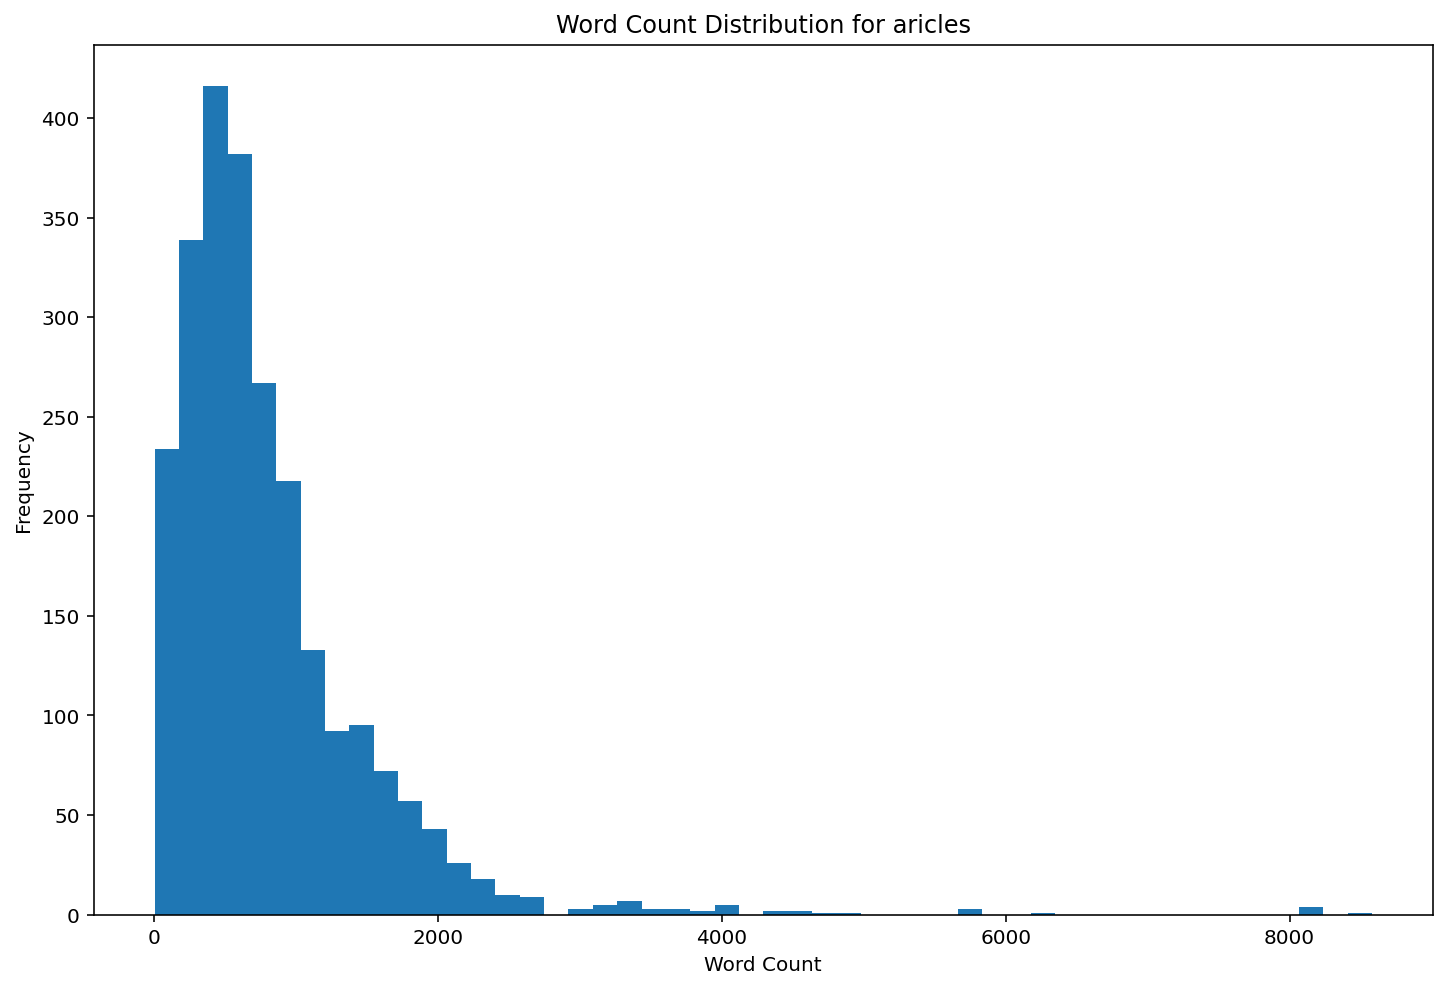

In [5]:
# Calculating the word count for articles
df['n_words'] = df['body_clean'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['n_words'].plot(kind='hist', bins = 50, figsize = (12,8),
                   title='Word Count Distribution for aricles');
plt.xlabel('Word Count');

In [6]:
# Explore the articles with more than 10k words 
long_articles = df.query(" n_words > 5000")
long_articles

,body,title,category,title_clean,body_clean,n_words
39,It's hard to say goodbye. A compilation of sta...,166 Startup Failure Post-Mortems,Startups & Business,startup failure post mortems,hard goodbye compilation startup failure post ...,8581
325,"Modern web development has many challenges, an...",Basics of Web Application Security: Authentica...,Engineering,basics application security authentication,modern development many challenges security im...,8236
326,"Modern web development has many challenges, an...",Basics of Web Application Security: Authorize ...,Engineering,basics application security authorize actions,modern development many challenges security im...,8236
327,"Modern web development has many challenges, an...",Basics of Web Application Security: Hash and S...,Engineering,basics application security hash salt users pa...,modern development many challenges security im...,8236
328,"Modern web development has many challenges, an...",Basics of Web Application Security: Protect Us...,Engineering,basics application security protect user sessions,modern development many challenges security im...,8236
349,"Last updated August 16, 2016\r\n\r\nComplexity...",Best Practices for Building a Microservice Arc...,Engineering,best practices building microservice architecture,last updated august complexity managed creep p...,5723
759,English ∙ 简体中文 | Brazilian Portuguese ∙ Italia...,GitHub - donnemartin/system-design-primer: Lea...,Engineering,github donnemartin system design primer learn ...,english brazilian portuguese italian japanese ...,5716
1769,"We use ad-blockers as well, you know. We gotta...",Taking The Pattern Library To The Next Level,Product & Design,taking pattern library next level,blockers well know gotta keep servers running ...,6323
2301,From financial fraud to just running out money...,Why Acceptance of Failure is Critical to Start...,Startups & Business,acceptance failure critical startup success,financial fraud running money scanned database...,5796


In [7]:
# Drop the words count column
df.drop(columns='n_words', inplace=True)

<br>

<a id='extract'></a>
## Step 1: Extract Features From Text
<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract"><b>Step 1: Extract Features From Text</b></a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

https://www.geeksforgeeks.org/feature-extraction-techniques-nlp/ <br>
**https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76**

### Bag of Words:
I think this model will work well if we used only titles
- The BoW model is used in document classification, where each word is used as a feature for training the classifier. There are 3 steps while creating a BoW model :

    - **The first step** is text-preprocessing which involves: converting the entire text into lower case characters. removing all punctuations and unnecessary symbols.
    - **The second step** is to create a vocabulary of all unique words from the corpus. 
    - **In the third step**, we create a matrix of features by assigning a separate column for each word, while each row corresponds to a review. This process is known as Text Vectorization. Each entry in the matrix signifies the presence(or absence) of the word in the review. We put 1 if the word is present in the review, and 0 if it is not present.

<font color='red'> A major drawback in using this model is that the order of occurence of words is lost, as we create a vector of tokens in randomised order. However, we can solve this problem by considering N-grams (mostly bigrams) instead of individual words (i.e. unigrams). This can preserve local ordering of words. </font>

### N-grams (mostly bigrams)
- <font color='red'>However, this table will come out to be very large, as there can be a lot of possible bigrams by considering all possible consecutive word pairs. </font>
- <font color='red'>Also, using N-grams can result in a huge sparse(has a lot of 0’s) matrix, if the size of the vocabulary is large, making the computation really complex!! </font>
- **Thus, we have to remove a few N-grams based on their frequency.**
    - Like, we can always remove **high-frequency N-grams**, because they appear in almost all documents. These high-frequency N-grams are generally articles, determiners, etc. most commonly called as **StopWords**.
    - Similarly, we can also remove **low frequency N-grams** because these are really rare(i.e. generally appear in 1 or 2 reviews)!! These types of N-grams are generally **typos** (or typing mistakes).
- Generally, medium frequency N-grams are considered as the most ideal.
- However, there are some N-grams which are really rare in our corpus but can highlight a specific issue.
    - Review: “Wi-Fi breaks often”.
    - Here, the N-gram ‘Wi-Fi breaks can’t be too frequent, but it highlights a major problem that needs to be looked upon.
    
<font color='red'>Our BoW model would not capture such N-grams since its frequency is really low. To solve this type of problem, we need another model i.e. TF-IDF Vectorizer, which we will study next. </font>

### TF-IDF Vectorizer : 
I think this would be the best method if we used the body and not the titles
- TF-IDF stands for term frequency-inverse document frequency.
- **It highlights a specific issue which might not be too frequent in our corpus but holds great importance.** 
- The TF–IFD value **increases** proportionally to the number of times a word appears in the document 
- and **decreases** with the number of documents in the corpus that contain the word. It is composed of 2 sub-parts, which are :
    - Term Frequency (TF)
    - Inverse Document Frequency (IDF)

### TF-IDF Vectorizer : 
I think this would be the best method if we used the body and not the titles

In [8]:
# calculating tf-idf values
from sklearn.feature_extraction.text import TfidfVectorizer  

# (1, 2) means unigrams and bigrams
tfidf = TfidfVectorizer(min_df = 1, ngram_range = (1, 1), stop_words='english') 
features = tfidf.fit_transform(df.body_clean)
  
X = pd.DataFrame(features.todense(), columns = tfidf.get_feature_names_out())   
print(X.shape)
X.head()

(2454, 40695)


,aabaco,aabb,aagaard,aaker,aalen,aamidor,aarhus,aaron,aarron,aatif,...,zuri,zurich,zuul,zwilling,zwillinger,zwol,zygmuntowicz,zylo,zynga,zzak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> **NOTE:**
> - I did not include bigrams as this needs high coputational power and the notebook crashes.

In [9]:
X.columns[:100]

Index(['aabaco', 'aabb', 'aagaard', 'aaker', 'aalen', 'aamidor', 'aarhus',
       'aaron', 'aarron', 'aatif', 'aaxaxaay', 'abac', 'aback', 'abacus',
       'abadi', 'abadie', 'abaj', 'abandon', 'abandoned', 'abandoning',
       'abandonment', 'abandonments', 'abandons', 'abbattista', 'abbreviate',
       'abbreviated', 'abbreviation', 'abbrevs', 'abby', 'abcs', 'abcxabc',
       'abdicate', 'abdicating', 'abductive', 'abdullah', 'abdy', 'abebooks',
       'abecassis', 'abel', 'abene', 'abercrombie', 'aberdare', 'aberrant',
       'aberration', 'abgr', 'abhishek', 'abhor', 'abhorrent', 'abid', 'abide',
       'abidi', 'abiding', 'abigail', 'abilities', 'ability', 'abject',
       'ablaze', 'able', 'ableton', 'ably', 'abnormal', 'abnormalities',
       'abnormally', 'aboard', 'abolish', 'abolishing', 'abominable', 'abort',
       'aborted', 'abortion', 'abortions', 'aborts', 'abound', 'abounds',
       'abour', 'aboutus', 'abovenet', 'abraham', 'abrahams', 'abramov',
       'abramovich',

In [10]:
# for col in df_features.columns:
#     if len(col) < 3: 
#         print(col)

**Drop all numeric column names**

In [11]:
# bool(regex.match(r'\d+.*', '00k'))

In [12]:
# columns_to_drop = []
# for col in df_features.columns:
#     if bool(regex.match(r'\d+.*', col)):
#         columns_to_drop.append(col)
        
# len(columns_to_drop)

In [13]:
# df_features.drop(columns=columns_to_drop, inplace=True)
# print(df_features.shape)
# df_features.head(1)

In [14]:
# df_features[(df_features != 0).any(axis=1)]

In [15]:
# 'your' in df_features.columns

<br>

### Bag of Words : 
I think this model will work well if we used only titles

In [16]:
# # Implementing Bag of Words in scikit-learn

# from sklearn.feature_extraction.text import CountVectorizer

# t0 = time()
# count_vector = CountVectorizer(stop_words='english')
# features_array = count_vector.fit_transform(df.title_clean).toarray()
# frequency_matrix = pd.DataFrame(features_array, columns=count_vector.get_feature_names())
# print(time()-t0)
# print(frequency_matrix.shape)
# frequency_matrix.head()

In [17]:
# 'your' in frequency_matrix.columns

In [18]:
# '"' in frequency_matrix.columns

In [19]:
# nltk.word_tokenize('01 margo to market fit: achieving sustainable growth')

In [20]:
# # Implementing Bag of Words Manually
# # By creating a list of dictionaries with words and their counts in each text

# def bag_of_words(text):
#     word2count = {}
#     words = nltk.word_tokenize(text) 
#     for word in words: 
#         if word not in word2count.keys(): 
#             word2count[word] = 1
#         else: 
#             word2count[word] += 1
            
#     return word2count

In [21]:
# dict_list = []
# for text in df.title:
#     dict_list.append(bag_of_words(text))

# frequency_matrix = pd.DataFrame(dict_list) 
# frequency_matrix.fillna(0, inplace=True)
# print(frequency_matrix.shape)
# frequency_matrix.head()

In [22]:
# frequency_matrix[(frequency_matrix != 0).any(axis=1)]

In [23]:
# 'your' in frequency_matrix.columns

<br>

**Drop StopWords, numeric, and not-alpha Columns**

**There are two methods:**
- We can add a clean_text column in the data, then use string methods --> **DONE**
- or we can extract features, then drop the unwanted columns

In [24]:
# columns_to_drop = []
# for col in frequency_matrix.columns:
#     if col in stop_words:
#         columns_to_drop.append(col)
#     if not col.isalpha():
#         columns_to_drop.append(col)
        
# len(columns_to_drop)

In [25]:
# frequency_matrix.drop(columns=columns_to_drop, inplace=True)
# print(frequency_matrix.shape)
# frequency_matrix.head(1)

<br>

<a id='reduce'></a>
## Step 2:  Dimensionality Reduction
1. Feature Selection
2. Feature Extraction (PCA) 

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce"><b>Step 2: Dimensionality Reduction</b></a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

## 1. Feature Selection

**Drop Correlated Columns** <br>
https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [26]:
# # This cell would take forever to run, as we have more dimensions
# # Identify correlations between numeric features
# t0 = time()
# columns_to_drop = helper.get_correlated_columns(df_features, 0.95)
# print(time()-t0)
# print(len(columns_to_drop))
# # columns_to_drop

In [27]:
# X = df_features.drop(columns=columns_to_drop)
# print(X.shape)
# X.head(1)

In [28]:
# X = df_features.copy()

In [29]:
# X.columns[:100]

> **NOTE:**
>- I wanted to keep columns which contain alphanumeric, I believed some of them would be helpful in the clustering,
> - But, I decided to remove them since they contained a lot of misleading features

In [30]:
# # Drop Numeric Columns
# columns_to_drop = []
# for col in X.columns:
#     if col.isdigit():
#         columns_to_drop.append(col)
        
# print(len(columns_to_drop))

In [31]:
# X.drop(columns=columns_to_drop, inplace=True)
# print(X.shape)
# X.head(1)

In [32]:
y = df.category.map({'Engineering': 0, 'Product & Design': 1, 'Startups & Business':2})
len(y)

2454

<br>

**https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features**

## 2. Feature Extraction 
PCA --> Principal Component Analysis

**All Data (Without Separation)**

> **NOTE:**
> - <font color='red'> **Don't scale features after BOW or TF-IDF** </font>
> - <font color='red'> We scale features to make sure all of them are treated the same (to avoid bias), </font>
> - <font color='red'> as the model understand larger values as more importat, **which is actually the case here!** </font>
> - <font color='red'> BOW or TF-IDF give higher values to most repeated words, which are more important </font>

https://stats.stackexchange.com/questions/65047/normalizing-term-frequency-for-document-clustering

TF/IDF usually is a two-fold normalization.

First, each document is normalized to length 1, so there is no bias for longer or shorter documents. This equals taking the relative frequencies instead of the absolute term counts. This is "TF".

Second, IDF then is a cross-document normalization, that puts less weight on common terms, and more weight on rare terms, by normalizing (weighting) each word with the inverse in-corpus frequency. Here it does not matter whether you use the absolute or relative frequency, as this amounts just to a constant factor across all vectors, so you will get different distances, but only by a constant factor (the corpus size).



In [33]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(X)

# X_scaled = pd.DataFrame(data_scaled, columns=list(X.columns))
# print(X_scaled.shape)
# X_scaled.head()

In [34]:
# X_scaled.describe() #Mean=0, Std=1

In [35]:
# Apply Random Projection to the data.
from sklearn import random_projection

t0 = time()
rp = random_projection.SparseRandomProjection()
X_rp = rp.fit_transform(X)
print(X_rp.shape)
time()-t0

(2454, 6690)


12.68669605255127

> **NOTE:**
>- Dimensionality reduced to only (40695) features instead of (6690)

<br>

https://stats.stackexchange.com/questions/363024/unsupervised-classification-vs-supervised-classification-when-data-labels-are-kn <br>
**https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features**

<a id='supervised'></a>
## Step 3: Build a Supervised Learning Model

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised"><b>Step 3: Build a Supervised Learning Model</b></a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

In [36]:
### Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
from xgboost import XGBClassifier

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_rp, y, test_size=0.2, random_state=42)

In [38]:
t0 = time()
# build a classifier
clf_xgb = XGBClassifier() # default --> n_estimators=100
clf_xgb.fit(X_train, y_train)
xgb_preds = clf_xgb.predict(X_test)

helper.print_metrics(y_test, xgb_preds, 'XGBClassifier')
print(time()-t0)

Accuracy score for XGBClassifier : 0.8513238289205702
198.59309601783752


In [72]:
t0 = time()
# build a classifier
clf_rf = RandomForestClassifier(n_estimators=220, random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

helper.print_metrics(y_test, rf_preds, 'RandomForestClassifier')
print(time()-t0)

Accuracy score for RandomForestClassifier : 0.8411405295315683
16.310996294021606


**Without Dimensionality Reduction (Random Projection)**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# t0 = time()
# # build a classifier
# clf_xgb = XGBClassifier()
# clf_xgb.fit(X_train, y_train)
# xgb_preds = clf_xgb.predict(X_test)

# helper.print_metrics(y_test, xgb_preds, 'XGBClassifier')
# print(time()-t0)

In [80]:
t0 = time()
# build a classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

helper.print_metrics(y_test, rf_preds, 'RandomForestClassifier')
print(time()-t0)

Accuracy score for RandomForestClassifier : 0.845213849287169
10.39816427230835


<br>

https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features

<a id='cluster'></a>
## Step 3: Filter & Cluster

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster"><b>Step 4: Filter & Cluster</b></a></li>
<li><a href="#end">End of Notebook</a></li>  
</ul>

><ul>
 <li><a href="#eng">Engineering</a></li>
 <li><a href="#product">Product & Design</a></li>
 <li><a href="#business">Startups & Business</a></li>
 </ul>

In [43]:
df.category.value_counts()

Startups & Business    1061
Product & Design        846
Engineering             547
Name: category, dtype: int64

In [44]:
print('category' in X.columns)
'article_category' in X.columns

True


False

In [47]:
# Add the category column to use in filtering
t0 = time()

X_to_filter = X.copy()
X_to_filter.insert(0, 'article_category', df.category)

print(time()-t0)
X_to_filter.head(1)

2.2550129890441895


,article_category,aabaco,aabb,aagaard,aaker,aalen,aamidor,aarhus,aaron,aarron,...,zuri,zurich,zuul,zwilling,zwillinger,zwol,zygmuntowicz,zylo,zynga,zzak
0,Startups & Business,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='eng'></a> 
### Feature Extraction (Engineering)
<ul>
<li><a href="#eng"><b>Engineering</b></a></li>
<li><a href="#product">Product & Design</a></li>
<li><a href="#business">Startups & Business</a></li>
</ul>

> **NOTE:**
> - Before we scale data and apply Feature Extraction, we will separate the articles by category.

In [48]:
df_eng = X_to_filter.query(" article_category == 'Engineering'")
X_eng = df_eng.iloc[:, 1:]
X_eng.reset_index(inplace=True, drop=True)
print(X_eng.shape)
X_eng.head(3)

(547, 40695)


,aabaco,aabb,aagaard,aaker,aalen,aamidor,aarhus,aaron,aarron,aatif,...,zuri,zurich,zuul,zwilling,zwillinger,zwol,zygmuntowicz,zylo,zynga,zzak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_eng_scaled = scaler.fit_transform(X_engineering) #Mean=0, Std=1

# X_eng_scaled = pd.DataFrame(data_eng_scaled, columns=list(X_engineering.columns))
# print(X_eng_scaled.shape)
# X_eng_scaled.head(1)

In [50]:
# Apply Random Projection to the data.
from sklearn import random_projection

t0 = time()
rp = random_projection.SparseRandomProjection()
X_eng_rp = rp.fit_transform(X_eng)
print(X_eng_rp.shape)
time()-t0

(547, 5403)


3.9641220569610596

<br>

## Clustering (Engineering)

In [51]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

> **NOTE:**
> - We will not use the original features, as this needs high computational power.
> - Instead, we will use the reduced features with random projection.

In [55]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_eng_rp)
    preds = model.predict(X_eng_rp)
    # Scoring
    sil_score = silhouette_score(X_eng_rp, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_eng_rp, preds)
    score = np.abs(model.score(X_eng_rp))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    # Print Results
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
    print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
    print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
    print('-'*50)
    
   
print((time()-t0)/60)

Clustering done for 2 k, with SSE 509.37
For n_clusters = 2, silhouette score is 0.01)
For n_clusters = 2, calinski_harabasz score is 7.11)
--------------------------------------------------
Clustering done for 3 k, with SSE 498.46
For n_clusters = 3, silhouette score is 0.03)
For n_clusters = 3, calinski_harabasz score is 9.58)
--------------------------------------------------
Clustering done for 4 k, with SSE 496.31
For n_clusters = 4, silhouette score is 0.02)
For n_clusters = 4, calinski_harabasz score is 7.18)
--------------------------------------------------
Clustering done for 5 k, with SSE 487.66
For n_clusters = 5, silhouette score is 0.02)
For n_clusters = 5, calinski_harabasz score is 7.88)
--------------------------------------------------
Clustering done for 6 k, with SSE 482.85
For n_clusters = 6, silhouette score is 0.03)
For n_clusters = 6, calinski_harabasz score is 7.43)
--------------------------------------------------
Clustering done for 7 k, with SSE 484.4
For n

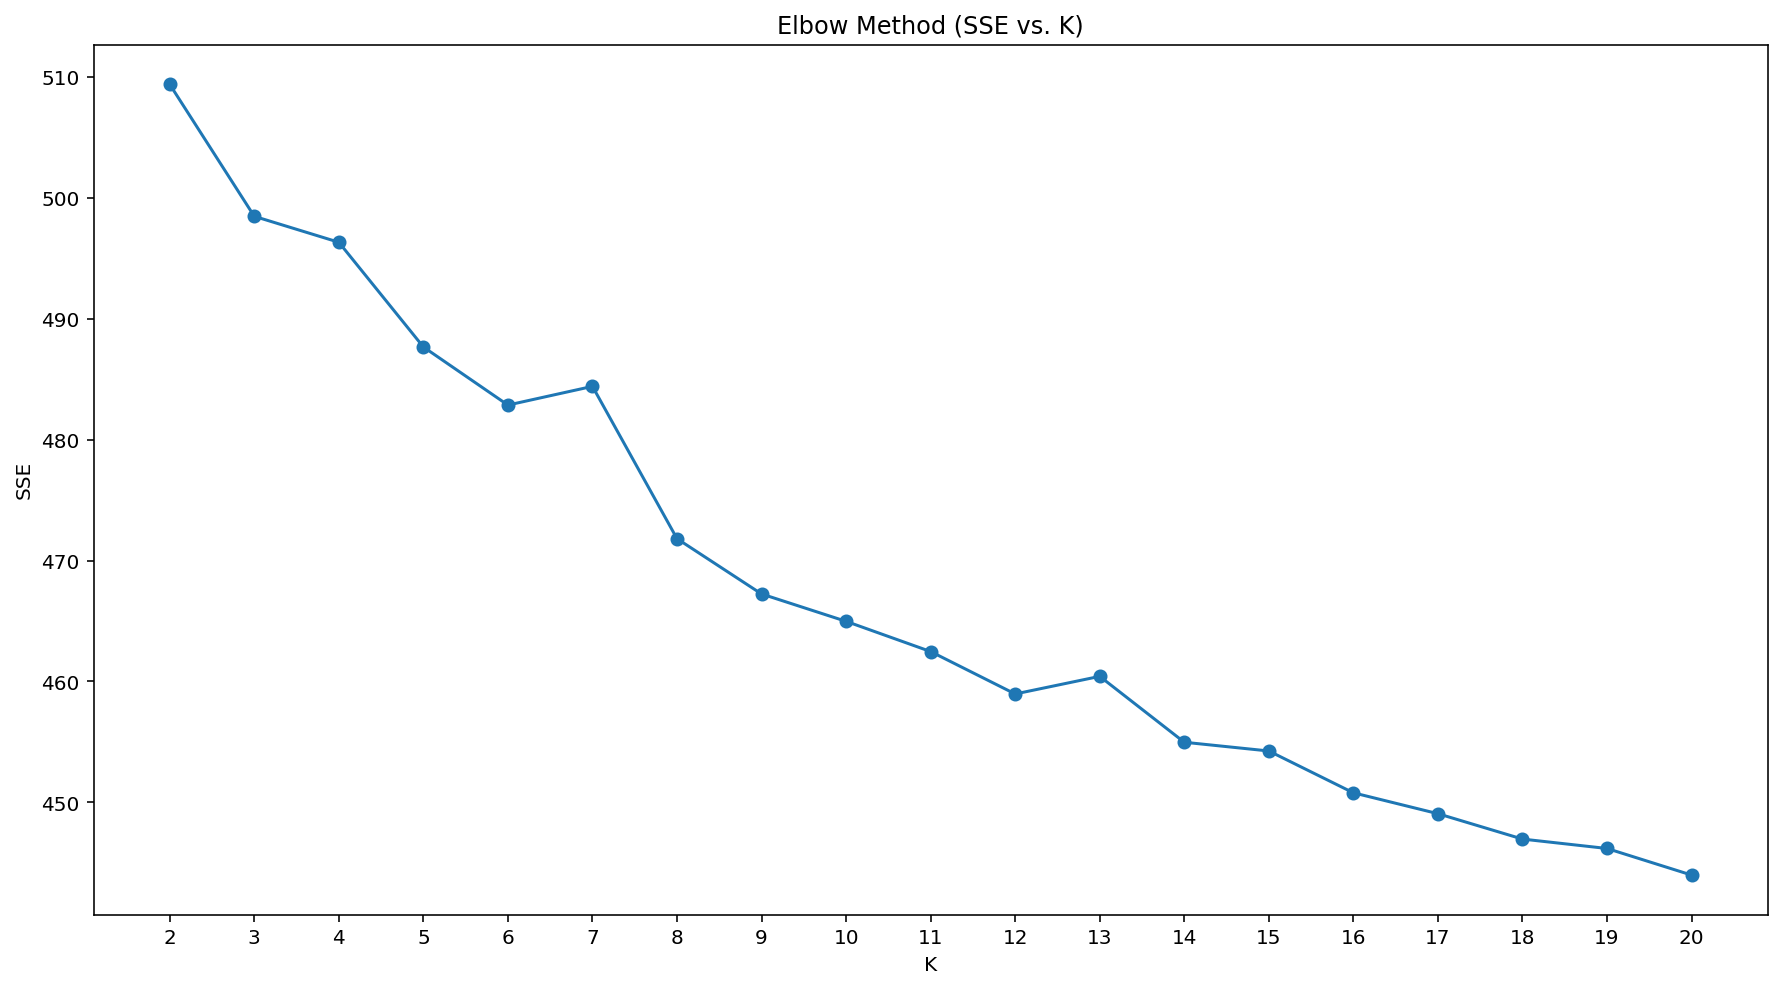

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Engineering)

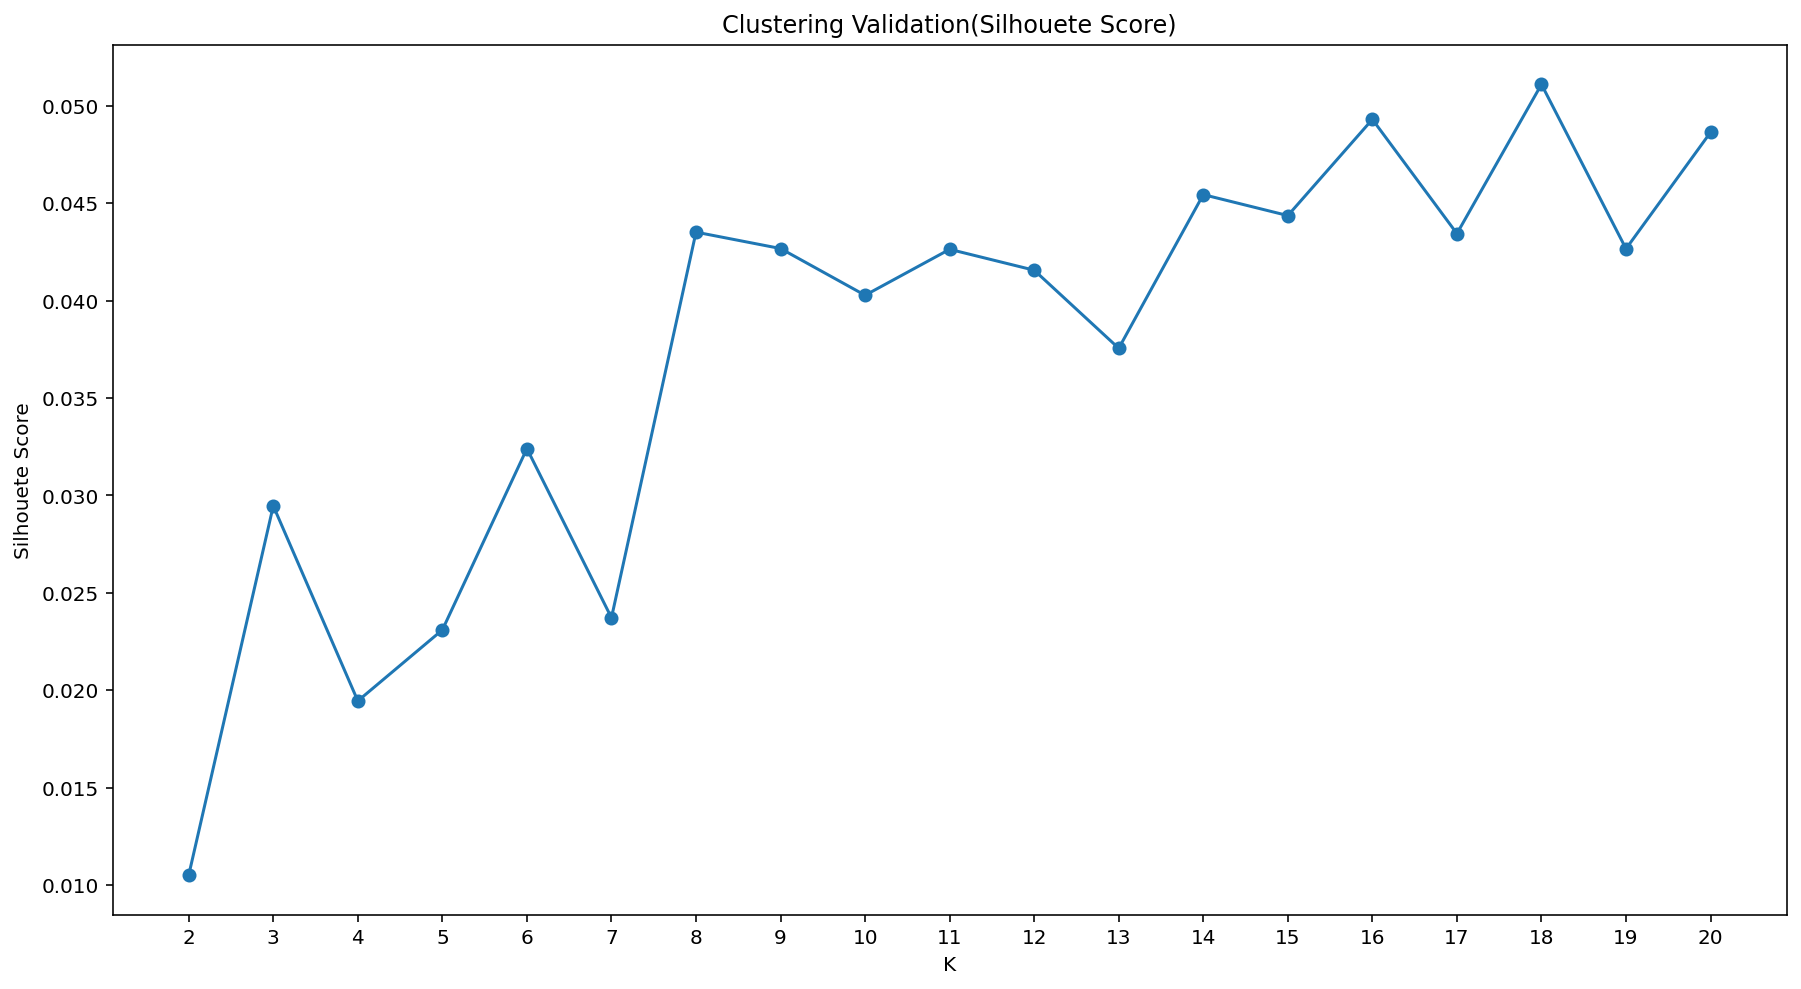

In [81]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouete Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

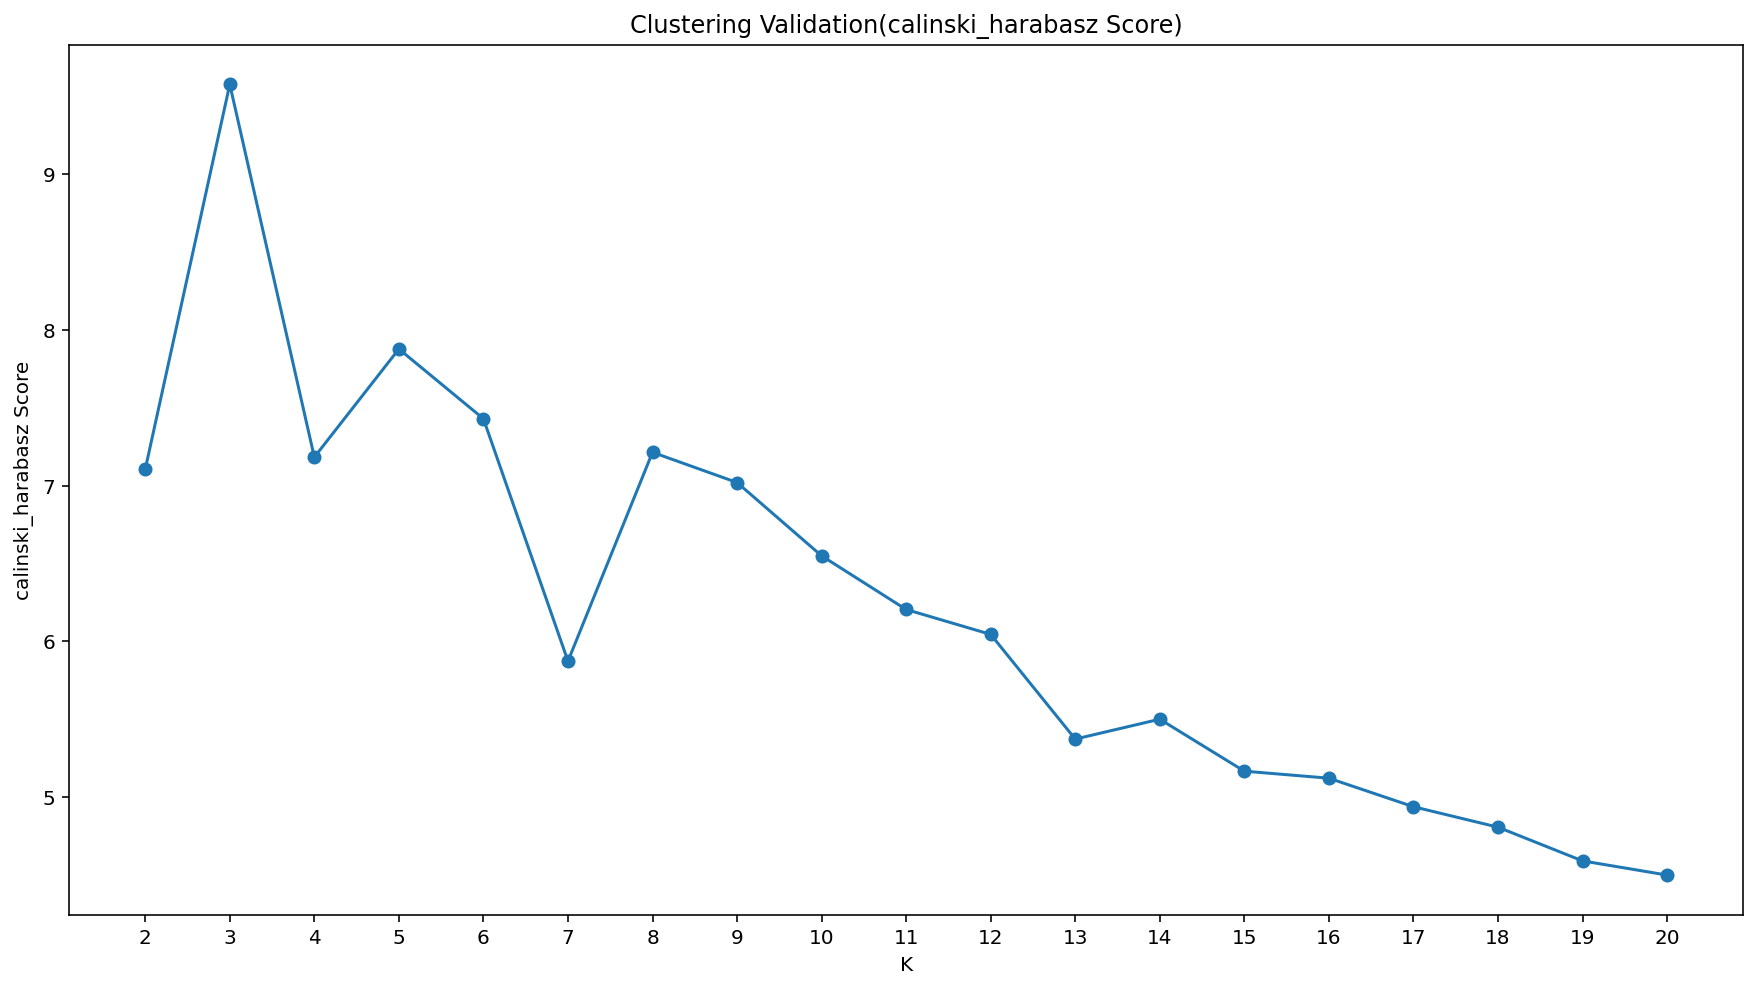

In [82]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

<br>

In [83]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_4 = KMeans(n_clusters=4, random_state=42)
model_eng = kmeans_4.fit(X_eng)
clusters_eng = model_eng.predict(X_eng) # Note: we used the original features

print(time()-t0)

6.832566976547241


In [84]:
clusters_eng

array([3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2,
       2, 2, 3, 2, 3, 2, 3, 2, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2,
       0, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2,
       3, 3, 3, 2, 0, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2,
       2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3,
       3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 0, 2, 3, 2, 2, 3, 3,
       3, 0, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2,
       2, 3, 3, 2, 3, 3, 3, 1, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2,
       2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 2,
       3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 1, 2, 3, 3, 3, 2, 2,
       3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3,

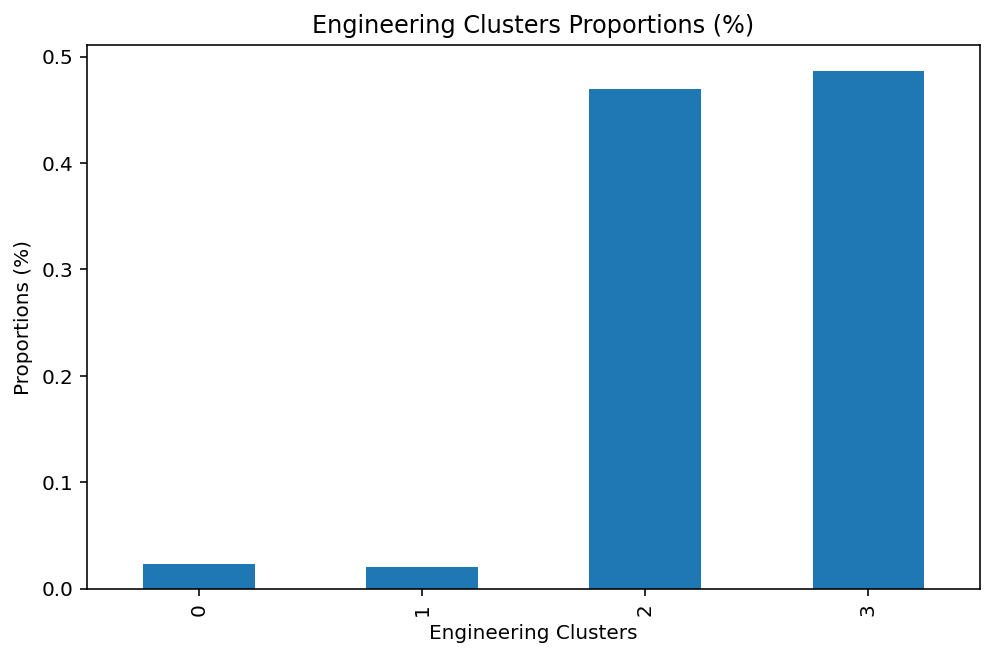

In [85]:
# Compare the proportion of data in each cluster 

# _c --> count
clusters_eng_c = pd.Series(clusters_eng).value_counts().sort_index()

# Calculate proprotions
prop_eng = clusters_eng_c / clusters_eng_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_eng.plot.bar(); # .sort_values(ascending=False)
plt.title('Engineering Clusters Proportions (%)')
plt.xlabel('Engineering Clusters');
plt.ylabel('Proportions (%)');

**Get the most important features(words) for cluster (0)**

In [97]:
centroid_eng_0 = pd.Series(model_eng.cluster_centers_[0]).sort_values(ascending=False)
centroid_eng_0.head(10)

31981    0.530361
12382    0.317284
27620    0.153019
19765    0.098461
13984    0.091614
35637    0.090995
1592     0.080764
25316    0.072069
35646    0.069538
14215    0.067986
dtype: float64

In [100]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
print(X.iloc[0, np.r_[tuple(centroid_eng_0.head(2).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_0.iloc[2:10].index)]].index.to_list()

(547, 40695)
['serverless', 'faas']


['processing',
 'lambda',
 'functions',
 'task',
 'application',
 'paas',
 'tasks',
 'gateway']

**Platform as a service (PaaS)** is a complete development and deployment environment in the cloud, with resources that enable you to deliver everything from simple cloud-based apps to sophisticated, cloud-enabled enterprise applications.

> **NOTE:**
> - cluster (0) --> mapped into ****

<br>

**Get the most important features(words) for cluster (1)**

In [101]:
centroid_eng_1 = pd.Series(model_eng.cluster_centers_[1]).sort_values(ascending=False)
centroid_eng_1.head(10)

22488    1.000000e+00
35982    1.734723e-18
38536    1.734723e-18
16163    1.734723e-18
18713    1.734723e-18
16619    1.734723e-18
12382    8.673617e-19
35999    8.673617e-19
30457    8.673617e-19
5103     8.673617e-19
dtype: float64

In [103]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
print(X.iloc[0, np.r_[tuple(centroid_eng_1.head(1).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_1.iloc[1:10].index)]].index.to_list()

(547, 40695)
['missing']


['test',
 'used',
 'high',
 'javascript',
 'http',
 'faas',
 'testing',
 'right',
 'cause']

**Function as a service** (faas) is a category of cloud computing services that provides a platform allowing customers to develop, run, and manage application functionalities without the complexity of building and maintaining the infrastructure typically associated with developing and launching an app. 

> **NOTE:**
> - cluster (1) --> mapped into ****

<br>

**Get the most important features(words) for cluster (2)**

In [104]:
centroid_eng_2 = pd.Series(model_eng.cluster_centers_[2]).sort_values(ascending=False)
centroid_eng_2.head(10)

8380     0.100595
8381     0.041948
20036    0.037093
21911    0.032143
22622    0.031382
28340    0.027708
20989    0.025487
19107    0.025020
6085     0.023913
23652    0.022514
dtype: float64

In [105]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
print(X.iloc[0, np.r_[tuple(centroid_eng_2.head(1).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_eng_2.iloc[1:10].index)]].index.to_list()

(547, 40695)
['data']


['database',
 'learning',
 'memory',
 'model',
 'query',
 'machine',
 'kafka',
 'cluster',
 'neural']

> **NOTE:**
> - cluster (2) --> mapped into **Machine Learning**

<br>

**Get the most important features(words) for cluster (3)**

In [106]:
centroid_eng_3 = pd.Series(model_eng.cluster_centers_[3]).sort_values(ascending=False)
centroid_eng_3.head(10)

6177     0.061824
22148    0.049418
28750    0.035071
31986    0.032387
31992    0.030609
36004    0.029423
1592     0.029164
18713    0.027791
6676     0.024528
8380     0.024170
dtype: float64

In [110]:
# Got an index error --> because we should locate columns and not rows
print(X_eng.shape)
X.iloc[0, np.r_[tuple(centroid_eng_3.head(10).index)]].index.to_list()

(547, 40695)


['code',
 'microservices',
 'react',
 'service',
 'services',
 'tests',
 'application',
 'javascript',
 'component',
 'data']

**React.js** is an open-source JavaScript library that is used for building user interfaces specifically for single-page applications. It's used for handling the view layer for web and mobile apps. React also allows us to create reusable UI components.

> **NOTE:**
> - cluster (2) --> mapped into **software design**

<br>

<a id='product'></a> 
### Feature Extraction (Product & Design)
<ul>
<li><a href="#eng">Engineering</a></li>
<li><a href="#product"><b>Product & Design</b></a></li>
<li><a href="#business">Startups & Business</a></li>
</ul>

In [86]:
df_prod = X_to_filter.query(" article_category == 'Product & Design'")
X_prod = df_prod.iloc[:, 1:]
print(X_prod.shape)
X_prod.head(1)

(846, 40695)


,aabaco,aabb,aagaard,aaker,aalen,aamidor,aarhus,aaron,aarron,aatif,...,zuri,zurich,zuul,zwilling,zwillinger,zwol,zygmuntowicz,zylo,zynga,zzak
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_prod_scaled = scaler.fit_transform(X_prod) #Mean=0, Std=1

# X_prod_scaled = pd.DataFrame(data_prod_scaled, columns=list(X.columns))
# print(X_prod_scaled.shape)
# X_prod_scaled.head(1)

In [88]:
# Apply Random Projection to the data.
t0 = time()

rp = random_projection.SparseRandomProjection()
X_prod_rp = rp.fit_transform(X_prod)
print(X_prod_rp.shape)

time()-t0

(846, 5777)


4.980475902557373

<br>

## Clustering (Product & Design)

In [89]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [90]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_prod_rp)
    preds = model.predict(X_prod_rp)
    # Scoring
    sil_score = silhouette_score(X_prod_rp, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_prod_rp, preds)
    score = np.abs(model.score(X_prod_rp))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    # Print Results
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
    print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
    print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
    print('-'*50)
    
   
print((time()-t0)/60)

Clustering done for 2 k, with SSE 771.41
For n_clusters = 2, silhouette score is 0.02)
For n_clusters = 2, calinski_harabasz score is 17.53)
--------------------------------------------------
Clustering done for 3 k, with SSE 759.99
For n_clusters = 3, silhouette score is 0.01)
For n_clusters = 3, calinski_harabasz score is 15.22)
--------------------------------------------------
Clustering done for 4 k, with SSE 752.5
For n_clusters = 4, silhouette score is 0.02)
For n_clusters = 4, calinski_harabasz score is 13.03)
--------------------------------------------------
Clustering done for 5 k, with SSE 746.4
For n_clusters = 5, silhouette score is 0.02)
For n_clusters = 5, calinski_harabasz score is 11.56)
--------------------------------------------------
Clustering done for 6 k, with SSE 741.36
For n_clusters = 6, silhouette score is 0.02)
For n_clusters = 6, calinski_harabasz score is 10.44)
--------------------------------------------------
Clustering done for 7 k, with SSE 740.49
F

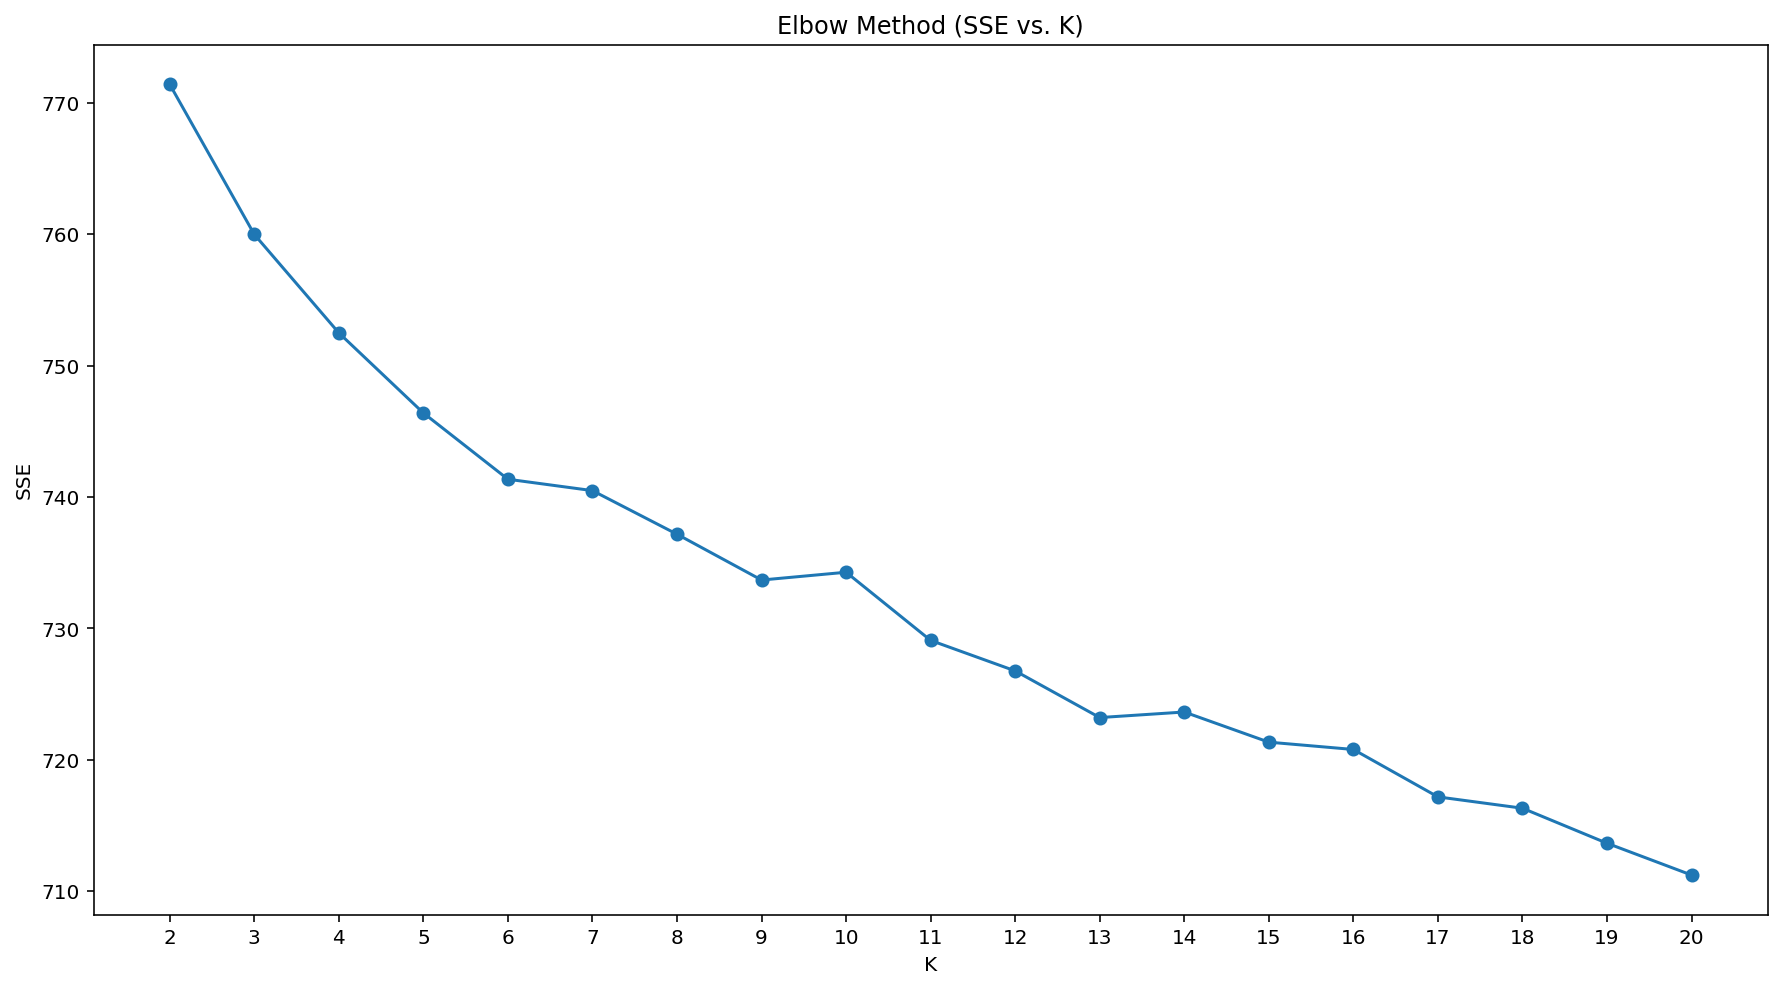

In [91]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Product & Design)

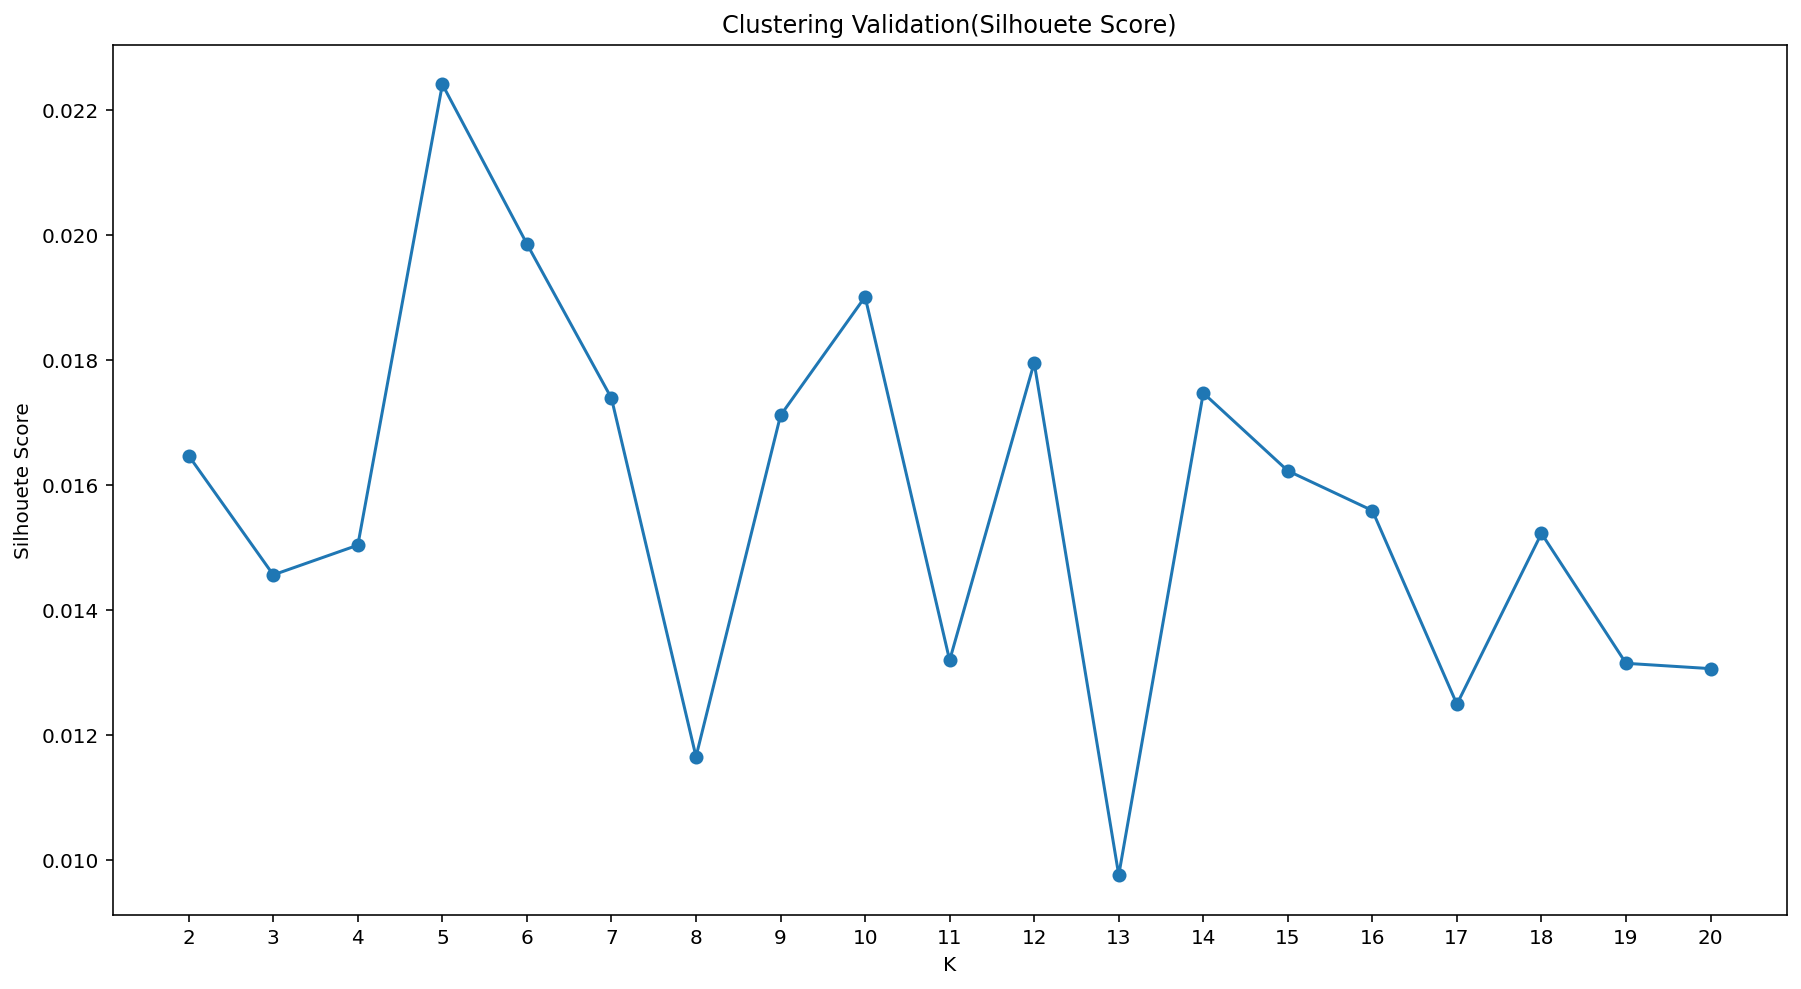

In [92]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouete Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

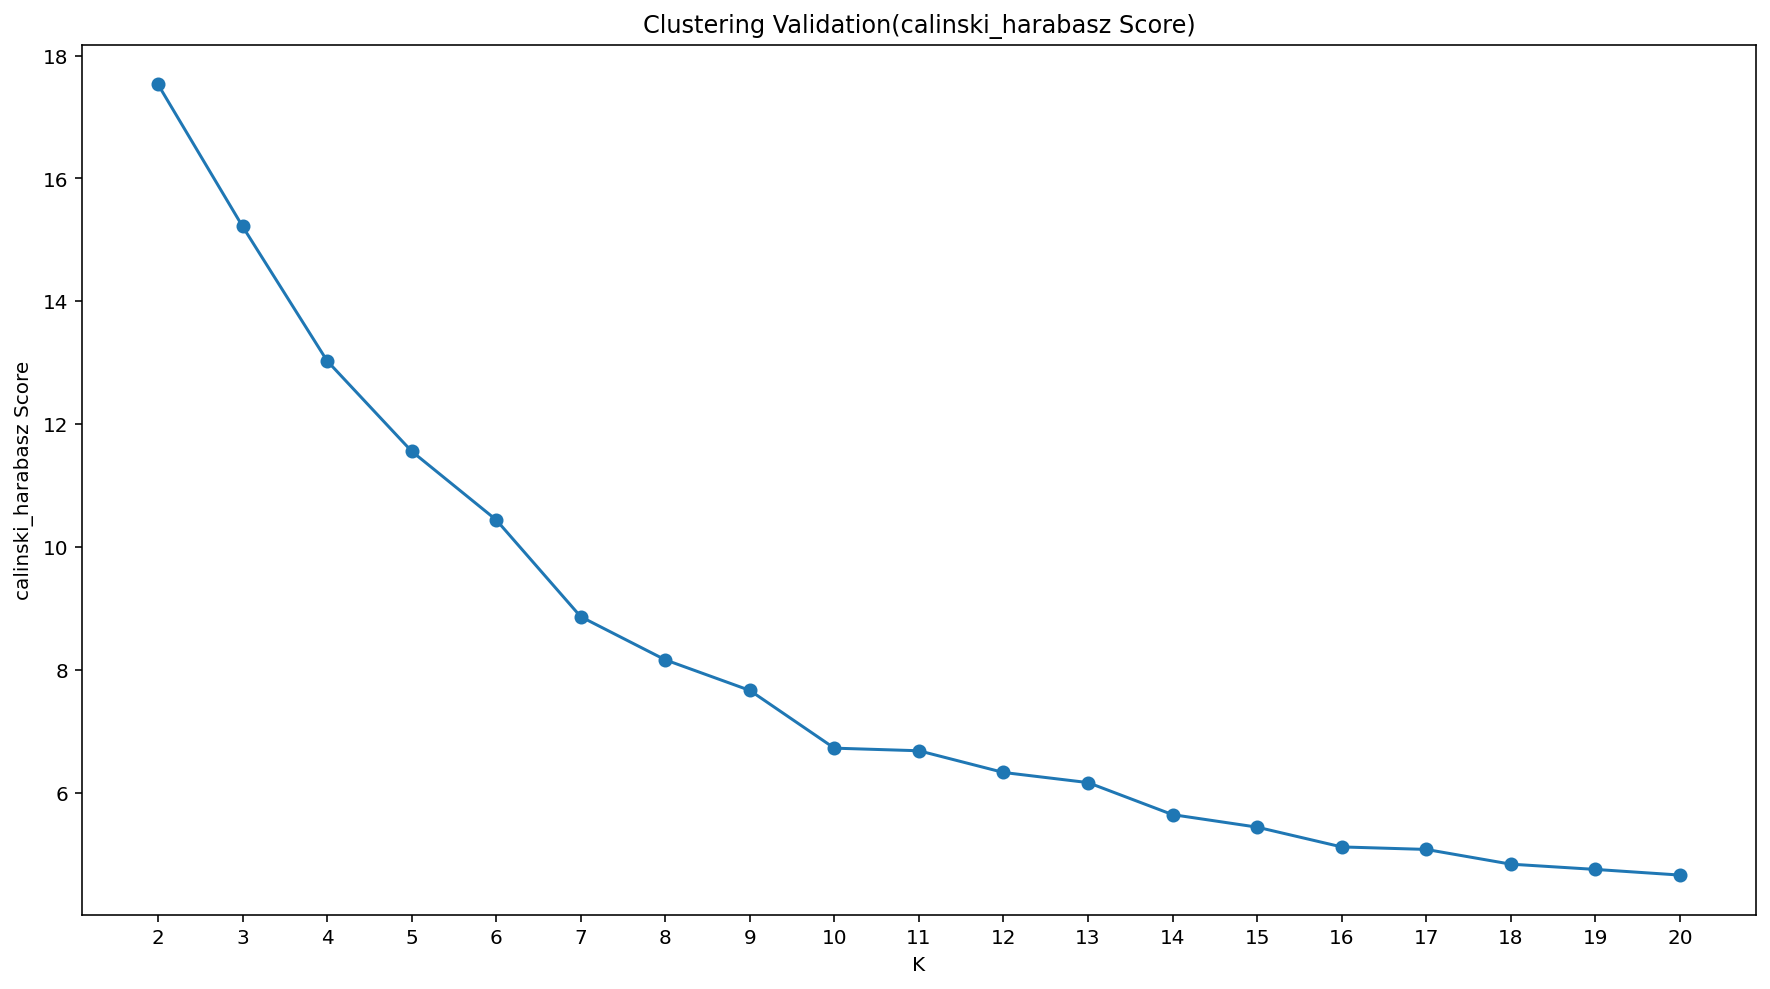

In [93]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

In [94]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_5 = KMeans(n_clusters=5, random_state=42)
model_prod = kmeans_5.fit(X_prod)
clusters_prod = model_prod.predict(X_prod)  # Note: we used the original features

print(time()-t0)

11.598995923995972


In [95]:
clusters_prod

array([1, 2, 3, 1, 1, 3, 3, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 4, 1, 1, 1, 1,
       1, 3, 1, 3, 1, 1, 4, 4, 4, 2, 4, 3, 4, 4, 3, 1, 1, 3, 1, 1, 1, 3,
       1, 3, 3, 3, 1, 4, 1, 2, 2, 1, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 3, 3,
       1, 4, 3, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 3, 1,
       3, 2, 4, 1, 3, 1, 4, 2, 1, 1, 3, 3, 3, 1, 3, 2, 3, 4, 3, 3, 1, 1,
       3, 1, 1, 1, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 2, 3,
       4, 3, 3, 2, 2, 3, 1, 2, 3, 4, 4, 3, 0, 1, 3, 1, 3, 1, 3, 3, 1, 2,
       2, 2, 4, 2, 3, 4, 3, 4, 2, 4, 4, 4, 3, 3, 3, 3, 4, 3, 3, 2, 3, 2,
       3, 3, 2, 2, 4, 3, 4, 1, 0, 2, 4, 4, 4, 4, 4, 3, 3, 4, 4, 2, 4, 4,
       4, 4, 3, 4, 0, 0, 4, 4, 3, 4, 4, 3, 3, 4, 3, 3, 1, 3, 1, 3, 3, 2,
       4, 4, 3, 2, 3, 3, 3, 4, 4, 1, 1, 4, 3, 4, 1, 3, 1, 2, 1, 4, 4, 3,
       1, 3, 3, 1, 4, 3, 3, 3, 1, 3, 1, 3, 4, 4, 1, 4, 3, 1, 3, 3, 3, 1,
       3, 1, 2, 1, 1, 1, 2, 0, 2, 3, 3, 2, 4, 4, 3, 3, 3, 4, 0, 4, 3, 4,
       3, 3, 4, 3, 1, 3, 1, 3, 3, 2, 4, 4, 3, 2, 4,

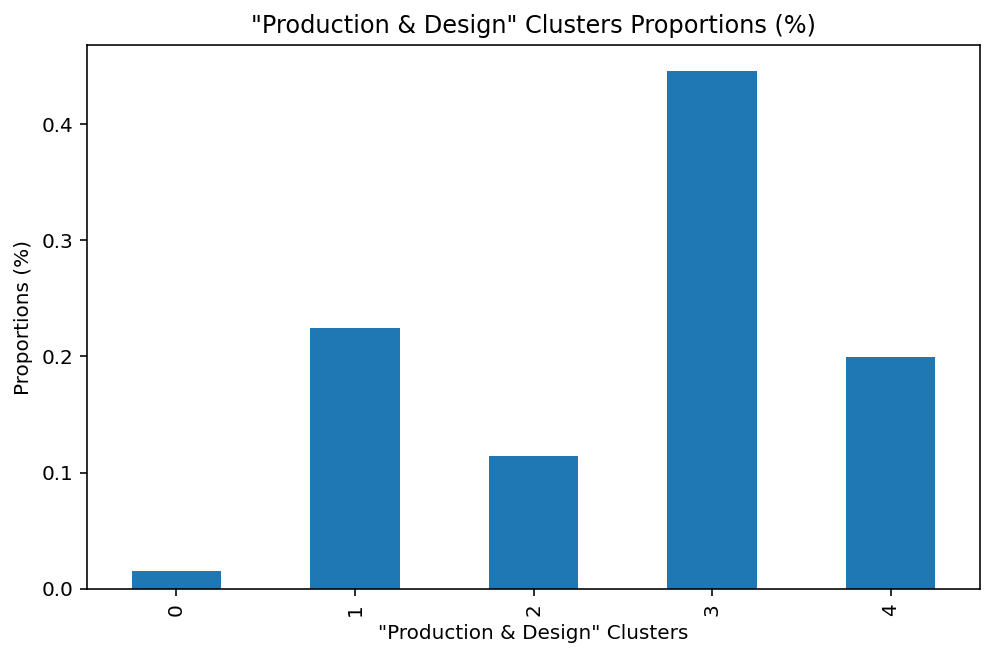

In [96]:
# Compare the proportion of data in each cluster 

# _c --> count
clusters_prod_c = pd.Series(clusters_prod).value_counts().sort_index()

# Calculate proprotions
prop_prod = clusters_prod_c / clusters_prod_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_prod.plot.bar(); # .sort_values(ascending=False)
plt.title('"Production & Design" Clusters Proportions (%)')
plt.xlabel('"Production & Design" Clusters');
plt.ylabel('Proportions (%)');

**Get the most important features(words) for cluster (0)**

In [111]:
centroid_prod_0 = pd.Series(model_prod.cluster_centers_[0]).sort_values(ascending=False)
centroid_prod_0.head(10)

33810    0.459206
33813    0.281493
9214     0.173790
35708    0.113036
33341    0.053671
29949    0.053336
26886    0.051732
8471     0.051253
27948    0.046925
27615    0.046366
dtype: float64

In [112]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_0.head(3).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_0.iloc[3:10].index)]].index.to_list()

(846, 40695)
['sprint', 'sprints', 'design']


['team', 'solutions', 'research', 'poornima', 'days', 'prototype', 'process']

> **NOTE:**
> - cluster (0) --> mapped into ****

<br>

**Get the most important features(words) for cluster (1)**

In [113]:
centroid_prod_1 = pd.Series(model_prod.cluster_centers_[1]).sort_values(ascending=False)
centroid_prod_1.head(10)

27662    0.313785
21189    0.068609
21191    0.065851
8194     0.065224
35708    0.058771
21187    0.055503
8191     0.054024
27692    0.049090
25968    0.037420
38543    0.036707
dtype: float64

In [114]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_1.head(1).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_1.iloc[1:10].index)]].index.to_list()

(846, 40695)
['product']


['manager',
 'managers',
 'customers',
 'team',
 'management',
 'customer',
 'products',
 'people',
 'user']

> **NOTE:**
> - cluster (1) --> mapped into ****

<br>

**Get the most important features(words) for cluster (2)**

In [115]:
centroid_prod_2 = pd.Series(model_prod.cluster_centers_[2]).sort_values(ascending=False)
centroid_prod_2.head(10)

38561    0.188071
38543    0.134298
24544    0.099001
27662    0.098516
22583    0.049383
25968    0.041476
8380     0.040928
12192    0.039133
8194     0.035768
35982    0.035266
dtype: float64

In [116]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
print(X.iloc[0, np.r_[tuple(centroid_prod_2.head(2).index)]].index.to_list())
X.iloc[0, np.r_[tuple(centroid_prod_2.iloc[2:10].index)]].index.to_list()

(846, 40695)
['users', 'user']


['onboarding',
 'product',
 'mobile',
 'people',
 'data',
 'experience',
 'customers',
 'test']

> **NOTE:**
> - cluster (2) --> mapped into ****

<br>

**Get the most important features(words) for cluster (3)**

In [117]:
centroid_prod_3 = pd.Series(model_prod.cluster_centers_[3]).sort_values(ascending=False)
centroid_prod_3.head(10)

27662    0.067042
25968    0.038593
35708    0.035019
8194     0.032256
8191     0.031132
36385    0.028214
20372    0.027763
9214     0.024964
21125    0.023908
40133    0.023685
dtype: float64

In [118]:
# Got an index error --> because we should locate columns and not rows
print(X_prod.shape)
X.iloc[0, np.r_[tuple(centroid_prod_3.head(10).index)]].index.to_list()

(846, 40695)


['product',
 'people',
 'team',
 'customers',
 'customer',
 'time',
 'like',
 'design',
 'make',
 'work']

> **NOTE:**
> - cluster (2) --> mapped into ****

<br>

<a id='business'></a> 
### Feature Extraction (Startups & Business)
<ul>
<li><a href="#eng">Engineering</a></li>
<li><a href="#product">Product & Design</a></li>
<li><a href="#business"><b>Startups & Business</b></a></li>
</ul>

In [119]:
df_business = X_to_filter.query(" article_category == 'Startups & Business'")
X_business = df_business.iloc[:, 1:]
print(X_business.shape)
X_business.head(1)

(1061, 40695)


,aabaco,aabb,aagaard,aaker,aalen,aamidor,aarhus,aaron,aarron,aatif,...,zuri,zurich,zuul,zwilling,zwillinger,zwol,zygmuntowicz,zylo,zynga,zzak
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# # Apply feature scaling to the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_business_scaled = scaler.fit_transform(X_business) #Mean=0, Std=1

# X_business_scaled = pd.DataFrame(data_business_scaled, columns=list(X_engineering.columns))
# print(X_business_scaled.shape)
# X_business_scaled.head(1)

In [121]:
# Apply Random Projection to the data.
t0 = time()

rp = random_projection.SparseRandomProjection()
X_business_rp = rp.fit_transform(X_business)
print(X_business_rp.shape)

time()-t0

(1061, 5971)


4.556849956512451

<br>

## Clustering (Startup & Business)

In [ ]:
# # Create a toy dataset to reduce computation time
# # Reduce the size to 25%
# X_pca_sample = X_pca[np.random.choice(X_pca.shape[0], int(df.shape[0]*0.25), replace=False)]

In [122]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
t0 = time()

sse = [] # Sum of Squared Errors
silhouette = []
calinski = []
k_range = np.arange(2, 21)

for k in k_range:
    kmeans = KMeans(k, random_state=42) # , max_iter=30
    model = kmeans.fit(X_business_rp)
    preds = model.predict(X_business_rp)
    # Scoring
    sil_score = silhouette_score(X_business_rp, preds) #, metric='cosine'
    calinski_score = calinski_harabasz_score(X_business_rp, preds)
    score = np.abs(model.score(X_business_rp))
    sse.append(score)
    silhouette.append(sil_score)
    calinski.append(calinski_score)
    # Print Results
    print('Clustering done for {} k, with SSE {}'.format(k, round(score, 2)))
    print("For n_clusters = {}, silhouette score is {})".format(k, round(sil_score, 2)))
    print("For n_clusters = {}, calinski_harabasz score is {})".format(k, round(calinski_score, 2)))
    print('-'*50)
    
   
print((time()-t0)/60)

Clustering done for 2 k, with SSE 969.91
For n_clusters = 2, silhouette score is 0.13)
For n_clusters = 2, calinski_harabasz score is 45.63)
--------------------------------------------------
Clustering done for 3 k, with SSE 959.55
For n_clusters = 3, silhouette score is 0.03)
For n_clusters = 3, calinski_harabasz score is 28.75)
--------------------------------------------------
Clustering done for 4 k, with SSE 950.37
For n_clusters = 4, silhouette score is 0.04)
For n_clusters = 4, calinski_harabasz score is 22.74)
--------------------------------------------------
Clustering done for 5 k, with SSE 943.48
For n_clusters = 5, silhouette score is 0.04)
For n_clusters = 5, calinski_harabasz score is 19.09)
--------------------------------------------------
Clustering done for 6 k, with SSE 937.98
For n_clusters = 6, silhouette score is 0.04)
For n_clusters = 6, calinski_harabasz score is 16.58)
--------------------------------------------------
Clustering done for 7 k, with SSE 931.73

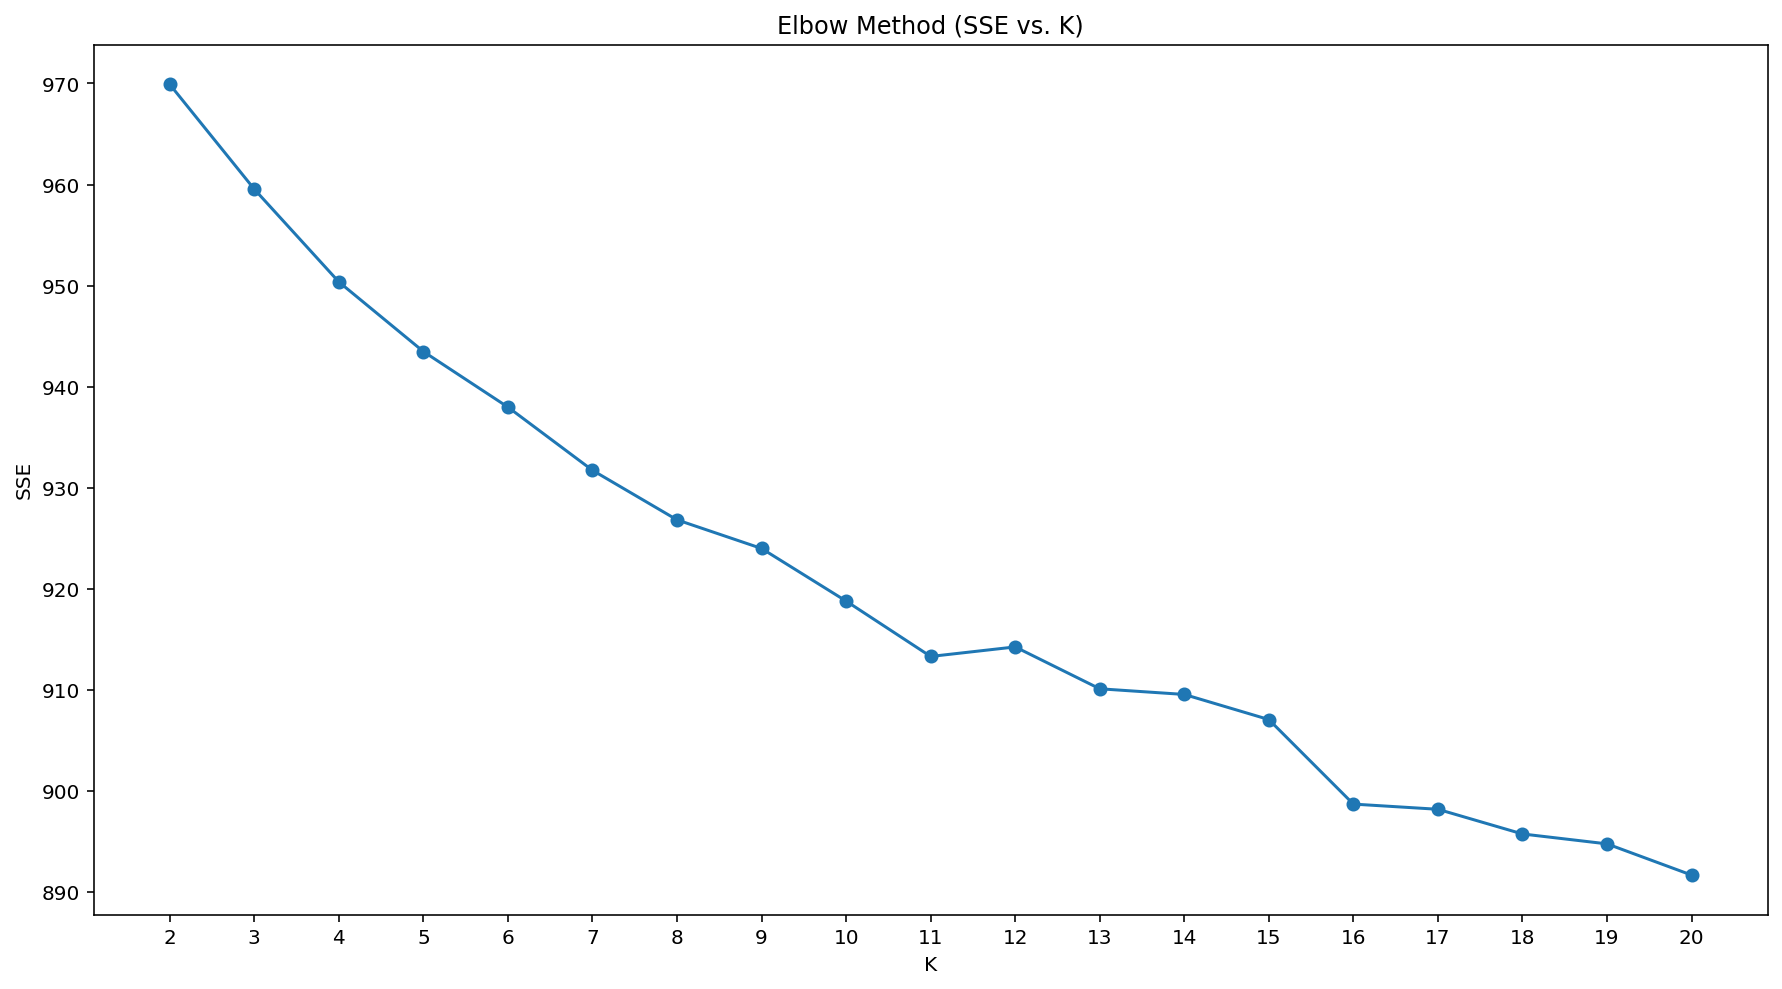

In [123]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method (SSE vs. K)')
plt.plot(k_range, sse, linestyle='-', marker='o');

## Clustering Validation (Startups & Business)

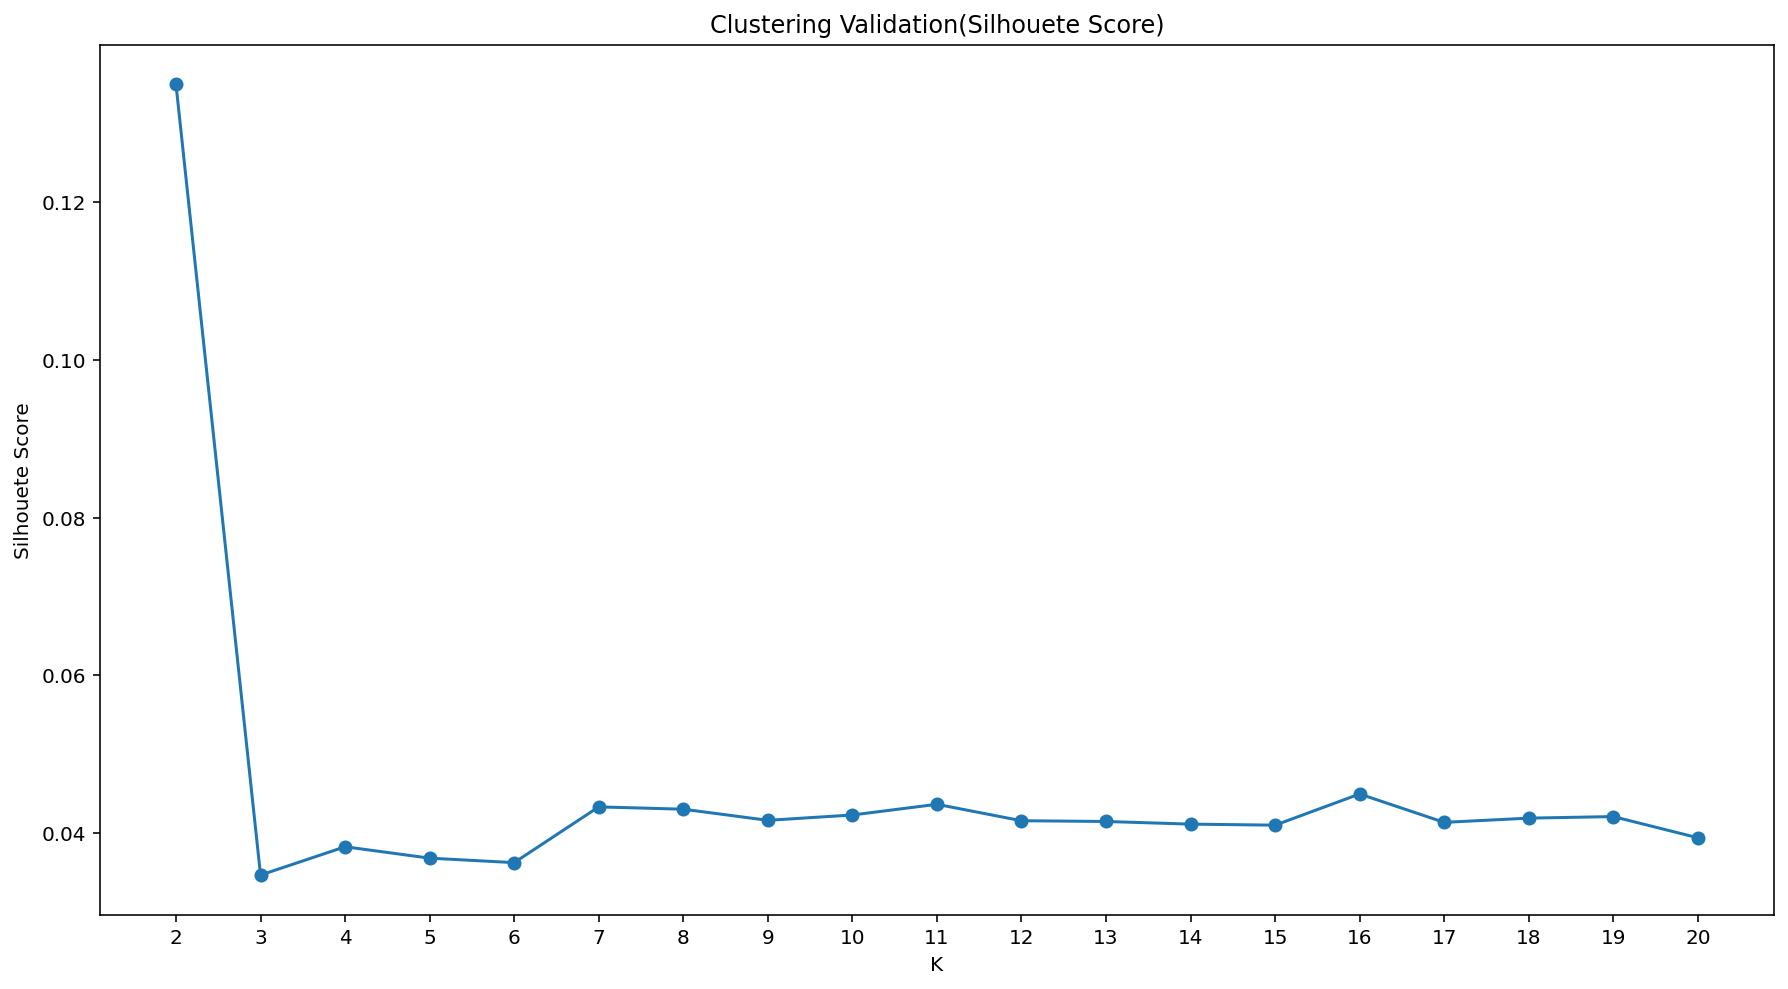

In [124]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('Silhouete Score')
plt.title('Clustering Validation(Silhouete Score)')
plt.plot(k_range, silhouette, linestyle='-', marker='o');

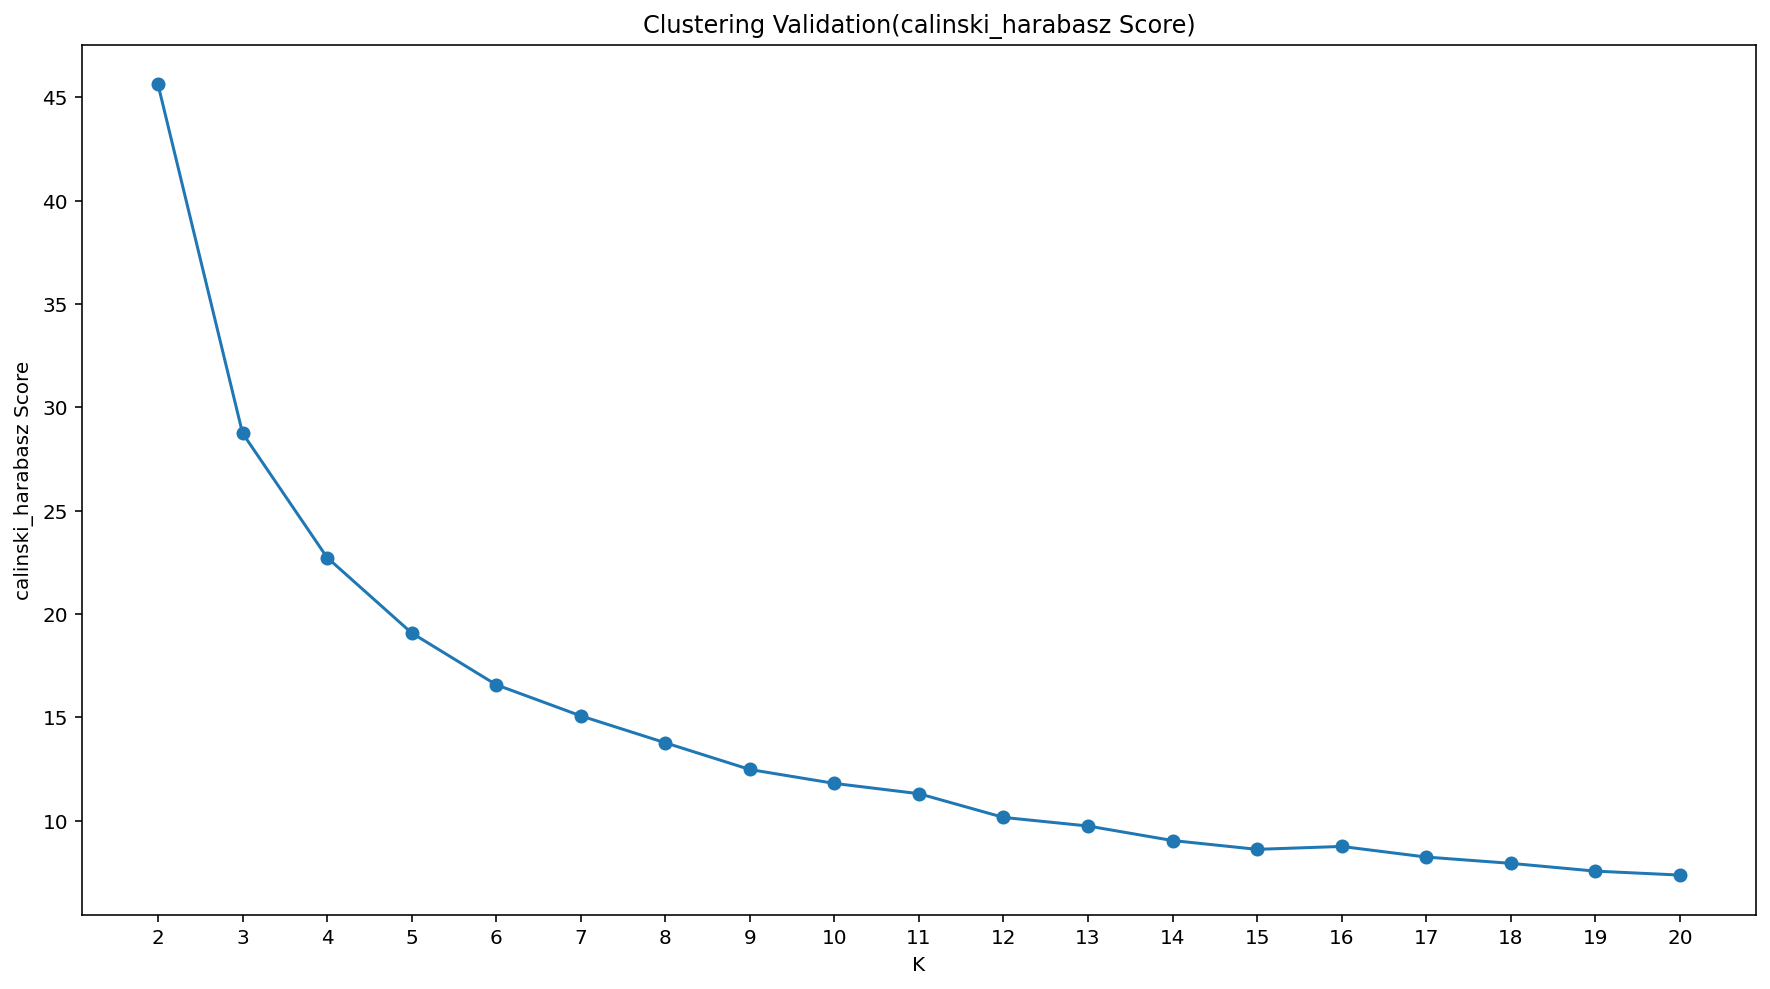

In [125]:
# Use the Silhouete Score Method to identify the right value of k
plt.figure(figsize=(15, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('calinski_harabasz Score')
plt.title('Clustering Validation(calinski_harabasz Score)')
plt.plot(k_range, calinski, linestyle='-', marker='o');

In [135]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
t0 = time()

kmeans_2 = KMeans(n_clusters=3, random_state=42)
model_st = kmeans_2.fit(X_business)
clusters_business = model_st.predict(X_business)

print(time()-t0)

10.401257038116455


In [136]:
# clusters_business

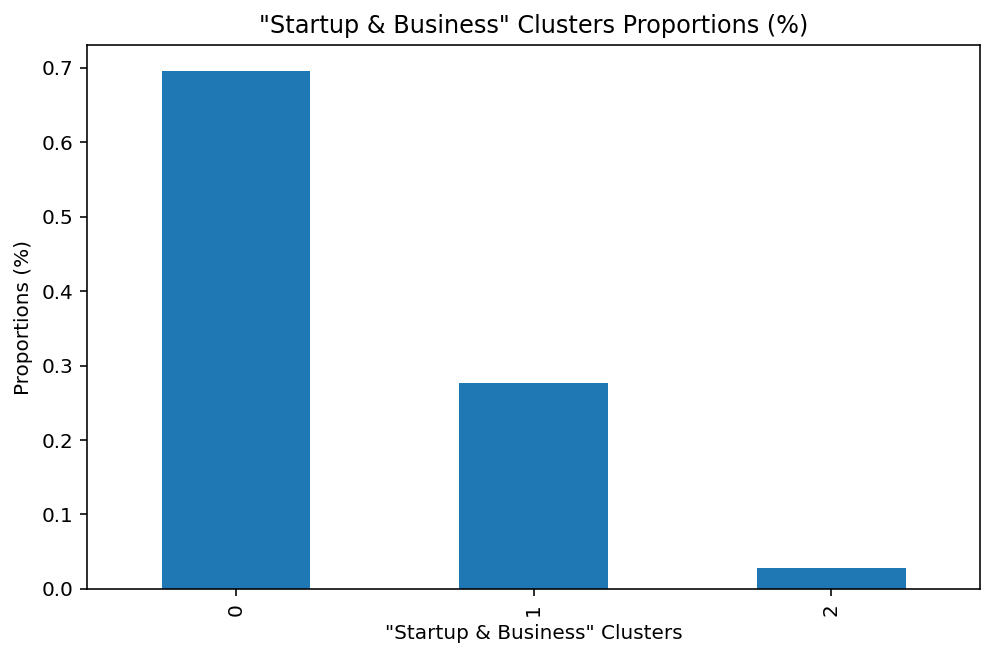

In [137]:
# Compare the proportion of data in each cluster 

# _c --> count, st --> startup
clusters_st_c = pd.Series(clusters_business).value_counts().sort_index()

# Calculate proprotions
prop_st = clusters_st_c / clusters_st_c.sum()

# PLOT
plt.figure(figsize=(8, 5))
prop_st.plot.bar(); # .sort_values(ascending=False)
plt.title('"Startup & Business" Clusters Proportions (%)')
plt.xlabel('"Startup & Business" Clusters');
plt.ylabel('Proportions (%)');

**Get the most important features(words) for cluster (0)**

In [131]:
centroid_st_0 = pd.Series(model_st.cluster_centers_[0]).sort_values(ascending=False)
centroid_st_0.head(10)

22488    1.000000e+00
21371    6.938894e-18
13658    6.938894e-18
35708    6.938894e-18
6561     6.938894e-18
23525    6.938894e-18
25968    6.938894e-18
35717    3.469447e-18
8380     3.469447e-18
11551    3.469447e-18
dtype: float64

In [132]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_0.head(10).index)]].index.to_list()

(1061, 40695)


['missing',
 'marketing',
 'founders',
 'team',
 'companies',
 'need',
 'people',
 'teams',
 'data',
 'entrepreneurs']

> **NOTE:**
> - cluster (0) --> mapped into **Startups Mistakes**

<br>

**Get the most important features(words) for cluster (1)**

In [129]:
centroid_st_1 = pd.Series(model_st.cluster_centers_[1]).sort_values(ascending=False)
centroid_st_1.head(10)

6563     0.051019
27662    0.044931
25968    0.044081
35708    0.039342
4476     0.034248
34063    0.033152
36385    0.032367
6561     0.029334
8194     0.028912
15242    0.027986
dtype: float64

In [130]:
# Got an index error --> because we should locate columns and not rows
print(X_business.shape)
X.iloc[0, np.r_[tuple(centroid_st_1.head(10).index)]].index.to_list()

(1061, 40695)


['company',
 'product',
 'people',
 'team',
 'business',
 'startup',
 'time',
 'companies',
 'customers',
 'growth']

> **NOTE:**
> - cluster (0) --> mapped into **Startups Mistakes**

<br>

<a id='end'></a>

<ul>
<li><a href="#load">Step 0: Load the Data</a></li>
<li><a href="#extract">Step 1: Extract Features From Text</a></li>
<li><a href="#reduce">Step 2: Dimensionality Reduction</a></li>
<li><a href="#supervised">Step 3: Build a Supervised Learning Model</a></li>
<li><a href="#cluster">Step 4: Filter & Cluster</a></li>
<li><a href="#end"><b>End of Notebook</b></a></li>  
</ul>

# End of Notebook

<br>